In [1]:
import dataclasses
import functools

import jax
from jax import numpy as jnp
import numpy as np

from flax import linen
from flax import struct
import optax
from tensorflow_probability.substrates import jax as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

import gym
from matplotlib import pylab as plt

import daves_rl_lib
from daves_rl_lib import networks
from daves_rl_lib.algorithms import deep_q_network
from daves_rl_lib.environments import environment_lib
from daves_rl_lib.internal import video_util

video_util.initialize_virtual_display()

Initialized virtual display.


In [2]:
buffer_size = 2048
epsilon = optax.exponential_decay(
    init_value=0.9,
    transition_steps=2000,
    decay_rate=0.1,
    end_value=1e-3)
discount_factor = 0.999
learning_rate = 0.01
gradient_batch_size = 32
target_weights_decay = 0.99

In [3]:
env = environment_lib.GymEnvironment(
    gym.make("CartPole-v1"), discount_factor=discount_factor)
qvalue_net = networks.make_model([24, 24, env.action_space.num_actions],
                                 obs_size=env.observation_size)
qvalue_optimizer = optax.adam(learning_rate)
learner = deep_q_network.initialize_learner(
    env=env,
    qvalue_net=qvalue_net,
    qvalue_optimizer=qvalue_optimizer,
    buffer_size=buffer_size,
    batch_size=None,
    seed=jax.random.PRNGKey(0))

step_learner = deep_q_network.compile_deep_q_update_step_stateful(
    env=env,
    qvalue_net=qvalue_net,
    qvalue_optimizer=qvalue_optimizer,
    gradient_batch_size=gradient_batch_size,
    target_weights_decay=target_weights_decay,
    epsilon=epsilon)
initial_obs = learner.agent_states.observation

In [4]:
actions = []
durations = []
returns = []
while len(durations) < 100:
    learner = step_learner(learner)
    if learner.agent_states.done:
        print("Episode {} finished after {} steps with return {:.2f}".format(
            len(durations),
            learner.agent_states.num_steps,
            learner.agent_states.episode_return))
        durations.append(learner.agent_states.num_steps)
        returns.append(learner.agent_states.episode_return)


Episode 0 finished after 13 steps with return 12.92
Episode 1 finished after 11 steps with return 10.95
Episode 2 finished after 33 steps with return 32.48
Episode 3 finished after 30 steps with return 29.57
Episode 4 finished after 40 steps with return 39.23
Episode 5 finished after 24 steps with return 23.73
Episode 6 finished after 16 steps with return 15.88
Episode 7 finished after 24 steps with return 23.73
Episode 8 finished after 29 steps with return 28.60
Episode 9 finished after 19 steps with return 18.83
Episode 10 finished after 39 steps with return 38.27
Episode 11 finished after 12 steps with return 11.93
Episode 12 finished after 29 steps with return 28.60
Episode 13 finished after 13 steps with return 12.92
Episode 14 finished after 20 steps with return 19.81
Episode 15 finished after 23 steps with return 22.75
Episode 16 finished after 28 steps with return 27.63
Episode 17 finished after 10 steps with return 9.96
Episode 18 finished after 41 steps with return 40.19
Epis

KeyboardInterrupt: 

Text(0.5, 1.0, 'Episode durations')

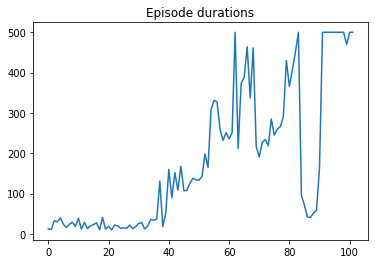

In [5]:
plt.plot(durations)
plt.title('Episode durations')

In [6]:
print("Estimated value", qvalue_net.apply(learner.qvalue_weights, initial_obs))
print("Mean reward", np.mean(
            learner.replay_buffer.valid_transitions().next_state.reward))

Estimated value [205.8733  209.16516]
Mean reward 1.0


In [7]:
images = []
# Collect frames to visualize.
for step in range(512):
    learner = step_learner(learner)
    images.append(env._gym_env.render(mode="rgb_array"))

In [8]:
video_util.display_frames(images, frames_per_second=15)